# Simulating the SIR model using the Gillespie algorithm

# Import modules
___

In [3]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

# plt.style.use('custom.mplstyle')
%config InlineBackend.figure_format = 'retina'

# Solving the SIR model using the Euler method
___

In the [first SIR model homework](https://github.com/StatPhysBio/biophysics/blob/main/part2/SIR_model.ipynb), we looked at the SIR model's system of differential equations and solved it using Euler's method. Using this deterministic model gave us the average $S(t)$ and $I(t)$. The code to solve for the average dynamics of the SIR model using Euler's method is included below for convenience since it will be used for comparison to the output from the Gillespie algorithm. There are some differences here compared to the function created and used in the previous homework. `s0` and `i0` are integers and represent the total counts of $S(0)$ and $I(0)$. Additionally, $N$, the total population is a parameter of the function. Be mindful of these parameters and read the docstring.

In [4]:
def euler_sir(s0, i0, n, r0, nu, T, dt):
    """
    Integrate the SIR system of differential equations using Euler's method.
    
    Parameters
    ----------
    s0 : float
        The initial size of the susceptible population.
    i0 : float
        The inital size of the infected population.
    n : int
        The size of the total population.
    r0 : float
        Average amount of susceptible individuals infected by an infected individual.
    nu : float
        The rate at which infected individuals recover or stop being infectious.
    T : float
        The total time over which the integration is performed.
    dt : float
        The size of the timestep (integration step).
    
    Returns
    -------
    times : numpy.ndarray
        Array of times at which the populations were evaluated.
    s : numpy.ndarray
        The evolution of the susceptible population over T, S(t).
    i : numpy.ndarray
        The evolution of the infected population over T, I(t).
    """
    num_steps = int(T / dt) + 1
    times = np.arange(num_steps) * dt
    
    s = np.zeros(shape=num_steps)
    i = np.zeros(shape=num_steps)
    
    s[0] = s0 
    i[0] = i0
    
    beta = r0 * nu / n
    
    for t in range(1, num_steps):
        ds = -beta * s[t - 1] * i[t - 1] * dt
        s[t] = s[t - 1] + ds
        i[t] = i[t - 1] - ds - nu * i[t - 1] * dt
        
    return times, s, i

# Computing stationary $S(t)$
___

In the [first SIR model homework](https://github.com/StatPhysBio/biophysics/blob/main/part2/SIR_model.ipynb), we also looked at stationary $S(t)$, i.e., $S(\infty)$. Code to compute $S(\infty)$ is included below for convenience. It will be used when looking at the stationary distribution produced by the output from the Gillespie algorithm. There are some differences here compared to the function created and used in the previous homework. `s0` and `i0` are integers and represent the total counts of $S(0)$ and $I(0)$. Additionally, $N$, the total population is a parameter of the function. Be mindful of these parameters and read the docstring.

In [5]:
def stationary_s(s0, i0, n, r0, maxiters=100, tol=1e-16):
    """
    Solve for S(\infty) using the method of iterations.
    
    Parameters
    ----------
    s0 : int
        The initial size of the population susceptible.
    i0 : int
        The inital size of the population infected.
    n : int
        The total size of the population
    r0 : float
        Average amount of susceptible individuals infected by an infected individual.
    tol : float
        Error tolerance.
    maxiters : int
        Maximum number of iterations to be performed.
        
    Returns
    -------
    s : float
        The solution to the transcendental equation for S(\infty).
    """
    s = s0
    r0_div_n = r0 / n
    c = i0 + s0 - np.log(s0)  / r0_div_n
    err = 100
    counter = 0
    
    while (err > tol) and (counter < maxiters):
        sol = np.exp((s - c) * r0_div_n)
        if s - sol == 0:
            return s
        err = np.abs((s - sol) / s)
        s = sol
        counter += 1
    
    return s

# Set up a random number generator
___

In [6]:
rng = np.random.default_rng(seed=0)

For this assignment, you can use `rng.random` and `rng.exponential` if you choose not to use Numba, or you can use `np.random.random` and `np.random.exponential` along with Numba.

# Introduction
____

Previously, we studied the SIR model using a system of differential equations and solved them using numerical integration and Euler's method. Now that we have a theoretical and programmatic understanding of the Gillespie algorithm, we can use it to simulate stochastic realizations of the SIR model and obtain solutions for the SIR master equation and steady-state distributions. As a reminder, the system of differential equations we are interested in is

$$
\begin{align*}
\frac{dS(t)}{dt} &= -\frac{\beta S(t) I(t)}{N} \\
\frac{dI(t)}{dt} &= \frac{\beta S(t) I(t)}{N} - \nu I(t) \\
\frac{dR(t)}{dt} &= \nu I(t)
\end{align*}
$$

$\beta > 0$ is the rate at which a susceptible person meeting an infected individual becomes infected. $\nu > 0$ is the rate at which infectious people recover. Both parameters have units of inverse time. **Here, $S$, $I$, and $R$ are not fractions of the population. They are integers representing how many individuals are in each respective population.** The variables are defined in this way because the reaction equations governing the SIR dynamics change the values of the populations by $\pm 1$ each time a reaction occurs.

Additionally, recall that the basic reproduction number $R_0$ is defined by

$$
R_0 = \frac{\beta}{\nu}
$$

$R_0$ gives the average amount of susceptible individuals infected by an infected individual. We will be using $(R_0, \nu)$ to parameterize the SIR dynamics instead of $(\beta, \nu)$.

The reaction equations for the SIR model are:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } k_i \\
S \rightarrow S - 1,\;\;\;\; & R_0 \nu S I / N \\[0.3em]
I \rightarrow I + 1, \;\;\;\; & R_0 \nu S I / N \\[0.3em]
I \rightarrow I - 1, \;\;\;\; & \nu I \\[0.3em]
R \rightarrow R + 1, \;\;\;\; & \nu I \\[0.3em]
\end{array}
\end{align}

The susceptible population decreases by 1 and the infected population increases by 1 at a rate given by $R_0 \nu S I /N$, where $S$ and $I$ are the current sizes of the susceptible and infected populations, respectively. The infected population decreases by 1 and the recovered population increases by 1 at a rate given by $\nu I$, the current size of the infected population.

Because $S + I + R = N$, we need not keep track of $R(t)$.

**Note**: We assume that the total population size $N$ remains constant. In this case, if an individual gets infected, then the number of infected individuals increases by 1 and (at the same time) the number of susceptible individuals decreases by 1. 

### **Question 1**: (15 points) Write a master equation for the dynamics of the joint probability density $p(S, I, t)$. Explain each term in your master equation. Note that, in this case, both $S$ and $I$ could change in a given time step. (20 pts)

**Hint:** think about the events (e.g., one person gets infected), and how these events impact the population sizes of susceptible and infected individuals.

We can write the time evolution of $p(S,I,t)$ using a master equation.

$$
\frac{d p(S, I ,t)}{dt} = -\frac{R_0𝜈SI}{N} p(S, I ,t) + \frac{R_0𝜈(S+1)(I-1)}{N} p(S+1, I-1, t) - 𝜈I p(S, I, t) + 𝜈(I+1) p(S, I+1, t)
$$

The first term represents the decrease of $p(S, I, t)$ due to $S$ transitioning to $S - 1$ and $I$ transitioning to $I + 1$ at rate $\frac{R_0𝜈SI}{N}$.

The second term represents a gain in $p(S, I, t)$ from $S+1$ transitioning to $S$ and $I - 1$ transitioning to $I$ which occurs at rate $𝜈I$. 

The third term describes the decrease of $p(S, I, t)$ from $I$ transitioning to $I-1$ at rate $𝜈(I+1)$. 

The final term describes in the increase in $p(S, I, t)$ from $S+1$ transitioning to $S$ and $I-1$ transitioning to $I$at rate $\frac{R_0𝜈(S+1)(I-1)}{N}$.

### **Question 2**: (15 points) Write a function that implements the Gillespie algorithm for simulating $S$ and $I$.

It should have as its parameters:
- `s0`, the initial size of the susceptible population
- `i0`, the initial size of the infected population
- `n`, the size of the total population
- `r0`, the basic reproduction number, indicating the average amount of susceptible individuals infected by an infected individual.
- `nu`, the rate at which infectious people recover
- `T`, the time at which the simulations should end 

It should return:
- `times`, a one-dimensional numpy array containing the times at which events occurred
- `s`, a one-dimensional numpy array containing the size of the susceptible population over the course of the simulation
- `i`, a one-dimensional numpy array containing the size of the infected population over the course of the simulation

You are free to use `@nb.njit` if you'd like (see Tutorial 5), but your code must be very similar to what was done in tutorial. Numba is very sensitive and things that might not be errors otherwise could be considered errors by Numba. **If you are not comfortable using it, you don't have to use it.**

**Hints:** 
- Initialize `times = [0.0]`. Using `times = [0]` will cause erroneous behavior for Numba. Otherwise, your code can highly _resemble_ what was done in Tutorial 5.
- Because `times` is expected to contain the times at which events occurred, use `s.append(s[-1])` if only `i` changes otherwise `s` and `times` will have different lengths and will not correspond correctly to one another.
- Because the infected population may become 0 over the course of the simulation, making both the rate of infection and recovery 0, the sum of the rates will be 0. This will result in the code breaking due to a division-by-zero error. In the spirit of what was used in Tutorial 5, write the following code right after the beginning of the while loop
```python
if i[-1] == 0:
    s.append(s[-1])
    i.append(i[-1])
    times.append(T)
    return np.array(times), np.array(s), np.array(i)
```

In [20]:
@nb.njit
def gillespie_sir(s0, i0, n, r0, nu, T):
    times = [0.0]
    s = [s0]
    i = [i0]
    time_elapsed = 0
    while time_elapsed <= T:
        if i[-1] == 0:
            s.append(s[-1])
            i.append(i[-1])
            times.append(T)
            return np.array(times), np.array(s), np.array(i)

        infected_rate = r0*nu*s[-1]*i[-1]/n
        recover_rate = nu * i[-1]
        
        """
        Save the total sum of the rates to a variable called sum_rates.
        """
        sum_rates = infected_rate + recover_rate

        """
        Use sum_rates and np.random.exponential to generate the time to the next event.
        Recall that np.random.exponential takes 1 / rate as its parameter.
        """
        interarrival_time = np.random.exponential(1 / sum_rates)

        """
        Add the above generated time to the time_elapsed.
        """
        time_elapsed += interarrival_time
        
        """
        Draw a random number using np.random.random().
        Use an if-else statement to determine whether the S/I increases
        or decreases by 1 by using the event probabilities.
        """        
        if np.random.random() <= infected_rate / sum_rates:
            s.append(s[-1]-1)
            i.append(i[-1]+1)
        else:
            s.append(s[-1])
            i.append(i[-1]-1)
        times.append(time_elapsed)
    return np.array(times), np.array(s), np.array(i)

### **Question 3:** (5 points) Store the results from 20 runs of the Gillespie algorithm using the following parameters:

- $N = 100 \, \mathrm{people}$
- $S_0 = 99\, \mathrm{people}$
- $I_0 = 1\, \mathrm{people}$
- $R_0 = 5$
- $\nu = \frac{1}{7} \, \mathrm{days}^{-1}$
- $T = 100 \, \mathrm{days}$

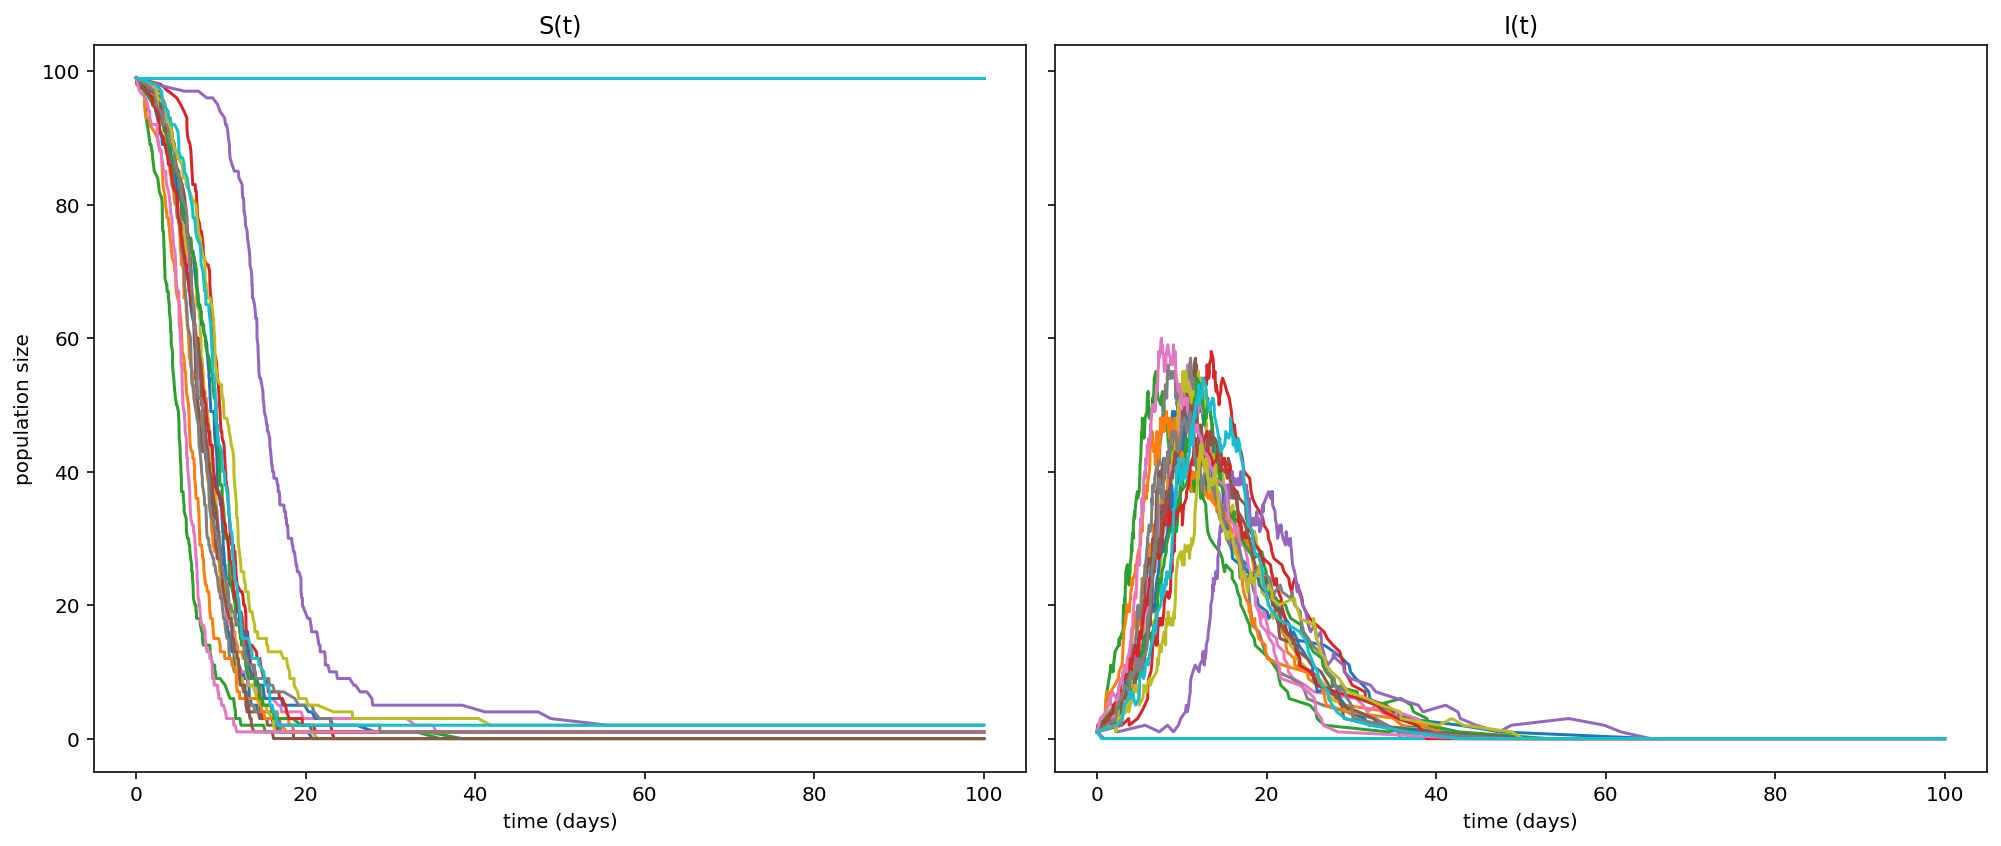

In [29]:
# s0=99
# i0=1
# n=100
# r0=5
# nu=1/7 
# T=100
# times, s, i = gillespie_sir(s0, i0, n, r0, nu, T)
# print(times)
# print(s)
# print(i)
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(14,6),sharey=True)
s0=99
i0=1
n=100
r0=5
nu=1/7 
T=100
"""
Use a for loop and run your simulation accordingly.
"""
for i in range(20):
    times, s, i = gillespie_sir(s0, i0, n, r0, nu, T)
    ax0.plot(times, s)
    ax1.plot(times, i)
    
ax0.set_xlabel('time (days)')
ax0.set_ylabel('population size')
ax0.set_title('S(t)')
ax1.set_xlabel('time (days)')
ax1.set_title('I(t)')

fig.tight_layout()
plt.show()

### **Question 4:** (10 points) Plot and compare your realizations with the average $S(t)$ and $I(t)$ obtained from solving the SIR differential equations with the Euler method. Create a figure with 2 axes, setting `sharey=True` and `sharex=True` (see Tutorial 5 for use). Plot $S(t)$ on one of axes, and plot $I(t)$ on the other. Plot the average $S(t)$ and $I(t)$ as a thick, black, dashed lines on their respective axes. Label your x- and y-axis appropriately. Set the x-axis limit to be $(0, T)$ using the $T$ from Question 3. Title the axes appropriately. No legend is necessary here.

For example, your plots may appear as

![gillepsie_realizations_plot](gillepsie_realizations_plot.png)

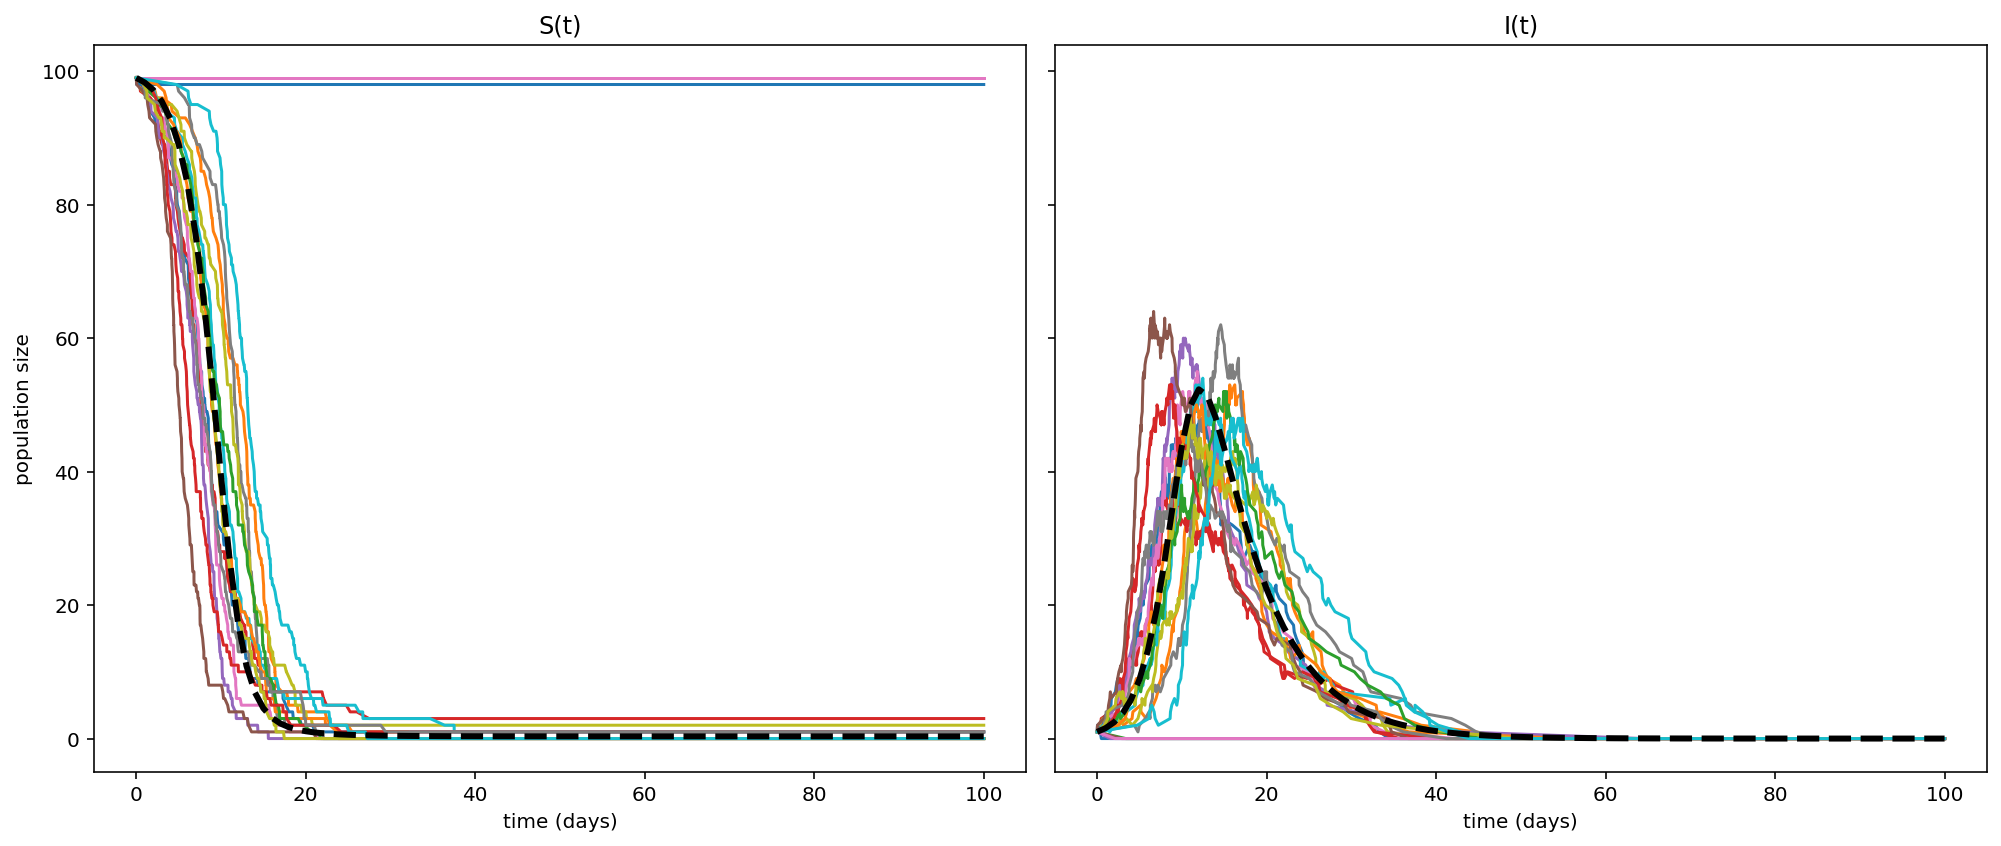

In [30]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(14,6),sharey=True)
s0=99
i0=1
n=100
r0=5
nu=1/7 
T=100
"""
Use a for loop and run your simulation accordingly.
"""
for i in range(20):
    times, s, i = gillespie_sir(s0, i0, n, r0, nu, T)
    ax0.plot(times, s)
    ax1.plot(times, i)

"""
Plot <s(t)> and <i(t)> from euler_sir method 
"""
times1 = np.linspace(0, 100, 100)
times1, s1, i1 = euler_sir(s0, i0, n, r0, nu, T, 1)

ax0.plot(times1, s1,
        color='black', linestyle='--', linewidth=3)
ax1.plot(times1, i1,
        color='black', linestyle='--', linewidth=3)
    
ax0.set_xlabel('time (days)')
ax0.set_ylabel('population size')
ax0.set_title('S(t)')
ax1.set_xlabel('time (days)')
ax1.set_title('I(t)')

fig.tight_layout()
plt.show()

### **Question 5:** (5 points) Store the steady state $S(t)$ from 10,000 runs of the Gillespie algorithm using the following parameters:

- $N = 1000 \, \mathrm{people}$
- $S_0 = 999\, \mathrm{people}$
- $I_0 = 1\, \mathrm{people}$
- $R_0 \in [2, 3, 5,10]$
- $\nu = \frac{1}{7} \, \mathrm{days}^{-1}$
- $T = 100 \, \mathrm{days}$

**Hint:** you should have 40,000 steady state $S(t)$, 10,000 for each $R_0$.

In [44]:
steady_state_s = np.zeros((4,10000))
steady_state_i = np.zeros((4,10000))
s0=999
i0=1
n=1000
r0=[2,3,5,10]
nu=1/7 
T=100
"""
Use a for loop and run your simulation for 10,000 times, storing the final S/I in steady_state_s and steady_state_i.
"""
for k in range(len(r0)):
  for idx in range(steady_state_s.shape[1]):
      times, s, i = gillespie_sir(s0, i0, n, r0[k], nu, T)
      steady_state_s[k][idx] = s[-1]
      steady_state_i[k][idx] = i[-1]

print(steady_state_s)
print(steady_state_i)


[[210. 999. 997. ... 998. 227. 214.]
 [999.  59. 999. ...  74. 999.  59.]
 [  9.   5.   4. ...   7.  13. 999.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[ 1.  0.  0. ...  0. 37.  3.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


### **Question 6:** (15 points) Create a figure with 4 axes, setting `sharey=True` and `sharex=True` (see Tutorial 5 for use). Make four histograms of the steady-state $S(t)$, one for each $R_0$. Use `stationary_s` (see top of notebook) to compute the expected steady-state $S(t)$, and use [`ax.axvline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html) (see SIR_model homework solutions or click [`ax.axvline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)) to plot this expected value using a black, dashed line. Use `density=True` and `bins=np.arange(0, n + 40, 20) - 10` (where `n` is $N$ specified in Question 5) for `ax.hist`. Label the axes appropriately. No legend is necessary here.

For example, your plots may appear as
![gillepsie_stationary_plot](gillepsie_stationary_plot.png)

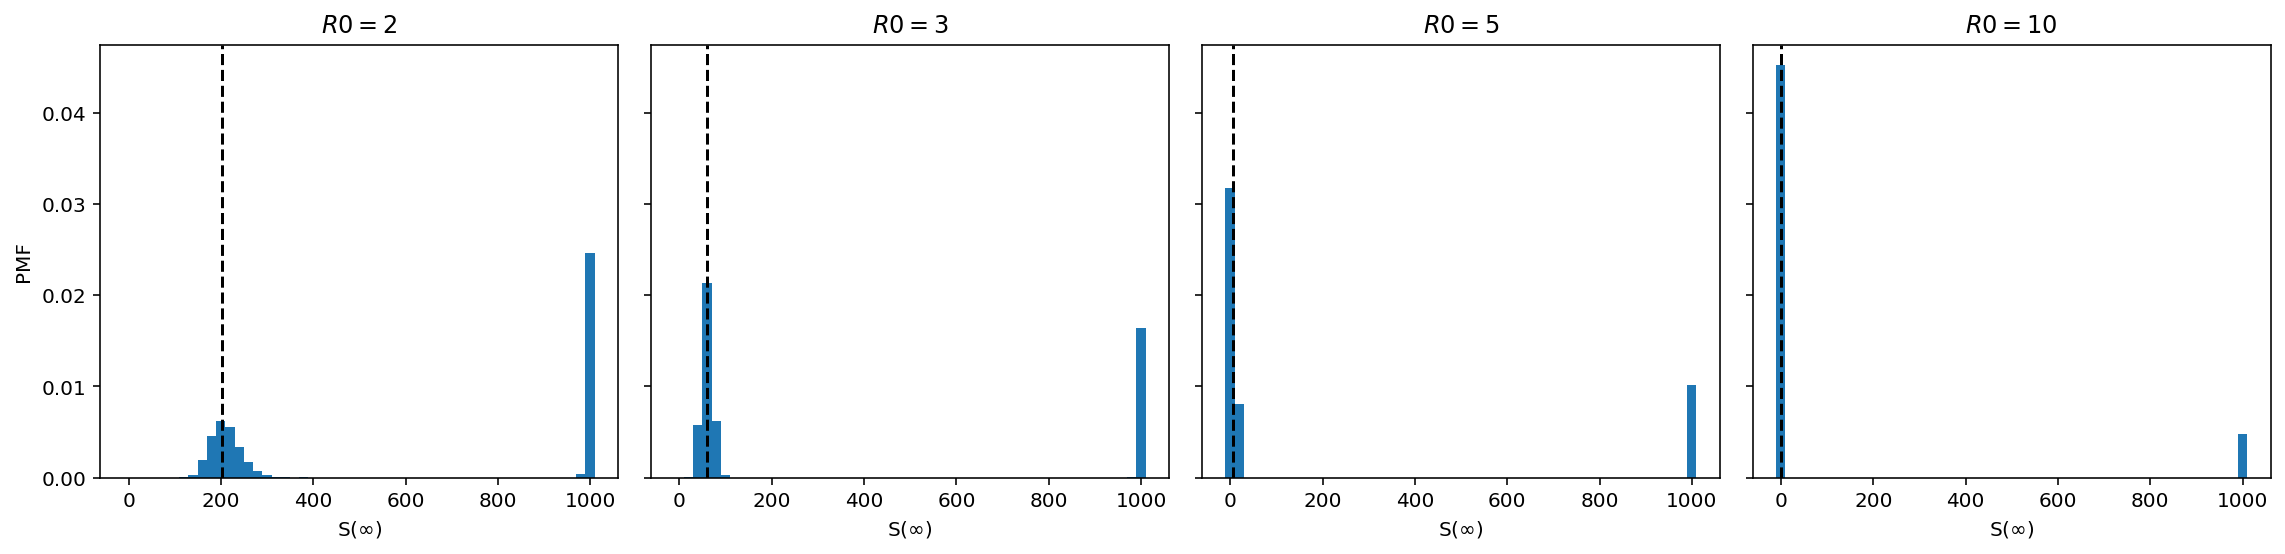

In [53]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4), sharey=True, sharex=True)

for k, ax in zip(range(len(r0)), np.ravel(axes)):    
    bins=np.arange(0, n + 40, 20) - 10
    centered_bins = bins - 0.5
    
    ax.hist(steady_state_s[k], bins=centered_bins, density=True, label='simulation')
    ss = stationary_s(s0, i0, n, r0[k], maxiters=100, tol=1e-16)
    ax.axvline(x=ss, color="black", linestyle="--")
    ax.set_title('$R0=' + str(r0[k]) +'$')
    ax.set_xlabel('S($\infty$)')
    
axes[0].set_ylabel('PMF')

fig.tight_layout()
plt.show()

### **Question 7:** (5 points) We see the distribution of $S(\infty)$ is bimodal. On the left hand side of each graph, we see a distribution with a mean that is consistent with the theoretical estimate from the deterministic SIR model. On the right hand side, we see a second mode of the distribution, indicating that in a fraction of realizations (simulation runs) the  asymptotic size of the susceptible population remains appoximately close to the size of the susceptible population at the beginning of the simulation $S(\infty) \approx S(0) $. Explain why we see such behavior.

Since in the end all the infected people are recovered, they become susceptible population again. They may have the second infection after they recovered. So the numbers of the recovered people are almost the same to the numbers of the susceptible population at the beginning of simulation 𝑆(∞)≈𝑆(0).